# Modelling the electricity consumption of our heat pump

**Background**: 
According to the International Energy Agency (IEA): "In 2021 about 8% of global energy-related and process-related CO2 emissions resulted from the use of fossil fuels in buildings, with another 19% from the generation of electricity and heat used in buildings."
So in 2021 we decided to have our natural gas supply line removed from our house and replaced the gas-heater with an electrically driven heat-pump that extracts heat from the outside air and uses that heat to warm up water that circulates in the floor of the house.
We also had solar panels installed on the roof to compensate for the added electricity demand from the heat-pump. 
Since the solar panels do not cover the entire electricity demand of our household, we import additional electricity that is generate entirely from renewable energy sources, such as wind, water and solar. 

**The goal of this analysis** is to be able to predict the electricity consumption of a newly installed heatpump in our home.

Unfortunately we can not measure the electricity used by the heatpump directely, but instead must deduce it's electricity demand from other data that I colleced in and around our house.

I am interested if I can predict the electricity demand of the heatpump with the help of this data. For example, I suspect that the amount of electricity the heatpump requires is dependend on factors such as to outside air temperature and the desired temperature in the house.

To build a model that can predict the electricity demand of the heatpump, I obtained data from:
- A weather station operated by the government 
- Thermometers placed inside and outside the house
- Solar panels placed on the roof
- A "smart meter" that is connected to the main electricity lines
- Data from provider from which we import additional electricity
- Data recorded about the manual changes I made to the settings of the heatpump

The following analysis is carried out in the jupyter notebook called "analysis_heatpump_electricity_demand.ipynb". You can find it in the same directory as this readme file. 
The analysis will run you through the following steps:

1. Obtain, import and clean the data required from various sources
2. Explore some of the data
3. Make certain assumptions about the data
4. Combine and analyse the data
5. Choose suitable predictor variables
6. Build a model to make predictions
7. Evaluate the model
8. Interpret the model
9. Make an 8-day forecast**

# Obtaining the data

## Public weather data from the nearest weather station

I suspect that some of the main factors that influence how hard the heat pump has to work are the outside air temperature, the wind and how much the house is warmed up by the sun.

The weather data recorded at the nearest location maintained by the dutch government is "Eelde", in North-East Netherlands. We retrieved it from the government website of the Dutch Meteorological Office: https://www.knmi.nl/nederland-nu/klimatologie/uurgegevens

The data is explained in a meta-data file, which you can find here: data\wx_knmi\uurgeg_280_2021-2030\uurgeg_280_2021-2030.txt

Before we begin this project we import the Python modules needed for it:

In [423]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

We then download and read the data into a pandas DataFrame:

In [424]:
# import Eelde weather data
import zipfile

url = 'https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/uurgegevens/uurgeg_280_2021-2030.zip'
weather = pd.read_csv(url, dtype=str, delimiter = ",", header = 28,compression='zip')

We select features that seem relevant at first glance:

In [425]:
# renaming and selecting columns
weather = weather.rename(columns={
'YYYYMMDD': "date_time", 
'   HH':"hour",
'   FH':"wind speed (m/s)",
'    T':'OAT (C)',
'   SQ':'sunshine duration (hrs)', 
'    Q':'global radiation (J/cm2)'})[['date_time','hour', 'wind speed (m/s)', 'OAT (C)', 'sunshine duration (hrs)','global radiation (J/cm2)']]

Further formating of the weather data:

In [426]:
# Formatting the date and time
weather['hour int'] = weather['hour'].astype(int)
weather['Time'] = pd.to_timedelta(weather['hour int'], unit='h')
weather['date_time'] = pd.to_datetime(weather['date_time'], utc=True)
weather['date_time'] = weather['date_time'] + weather['Time']\

# converting utc times to Amsterdam time
weather['date_time'] = weather['date_time'].map(lambda x: x.tz_convert('Europe/Amsterdam')) 

# creating date/time index column
weather = weather.set_index(['date_time'])

# dropping columns no longer required
weather = weather.drop(['hour','hour int', 'Time'], axis=1)

# and localizing the timestamps again, so it can later be combined with other data
weather = weather.tz_localize(None)

# converting data types
weather['wind speed (m/s)'] = weather['wind speed (m/s)'].astype('float')/10
weather['OAT Eelde (C)'] = weather['OAT (C)'].astype('float')/10
weather['sunshine duration (hrs)'] = weather['sunshine duration (hrs)'].astype('float')
weather['global radiation (J/cm2)'] = weather['global radiation (J/cm2)'].astype('float')

weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17592 entries, 2021-01-01 02:00:00 to 2023-01-04 01:00:00
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wind speed (m/s)          17592 non-null  float64
 1   OAT (C)                   17592 non-null  object 
 2   sunshine duration (hrs)   17592 non-null  float64
 3   global radiation (J/cm2)  17592 non-null  float64
 4   OAT Eelde (C)             17592 non-null  float64
dtypes: float64(4), object(1)
memory usage: 824.6+ KB


The weather data is given in hourly reports. <br>
We will aggregate certain features into daily summaries that we will need later:

In [427]:
# Obtaining the daily means of wind and temperature:
wind_temp = weather[["wind speed (m/s)", "OAT Eelde (C)"]]
wind_temp_daily = wind_temp.resample('1D').mean()
wind_temp_daily = wind_temp_daily.rename(columns={
'wind speed (m/s)': "wind speed (m/s) daily mean", 
'OAT Eelde (C)': "OAT Eelde (C) daily mean"})[["OAT Eelde (C) daily mean","wind speed (m/s) daily mean"]]
wind_temp_daily.head()

,OAT Eelde (C) daily mean,wind speed (m/s) daily mean
date_time,,
2021-01-01,1.781818,2.590909
2021-01-02,3.462500,2.291667
2021-01-03,3.362500,4.375000
2021-01-04,2.704167,7.166667
2021-01-05,2.500000,5.833333


In [428]:
# Obtaining the daily sums of solar radiation and sunshine duration
sun_radiation = weather[["sunshine duration (hrs)", "global radiation (J/cm2)"]]
sun_radiation_daily = sun_radiation.resample('1D').sum()
sun_radiation_daily = sun_radiation_daily.rename(columns={
"sunshine duration (hrs)": "sunshine duration (hrs) daily sum", 
"global radiation (J/cm2)":"global radiation (J/cm2) daily sum"})[["sunshine duration (hrs) daily sum","global radiation (J/cm2) daily sum"]]

sun_radiation_daily.head()

,sunshine duration (hrs) daily sum,global radiation (J/cm2) daily sum
date_time,,
2021-01-01,17.0,192.0
2021-01-02,0.0,118.0
2021-01-03,14.0,166.0
2021-01-04,0.0,92.0
2021-01-05,0.0,57.0


## Data from the Solar Panels

We need this data to calculate the total electricity demand of the house. 

The reason is that we can measure how much electricity we imported or exported  from and to the public electricity grid, but not how much we actually consumed. That is because the amount that we consume while electricity is produced by the solar panels does not register anywhere. However, we can measure how much we produced with the solar panels and thus arrive at the figure we are looking for.

The data from the solar panels is retrieved from the inverter that is connected to the panels. It has a temporal resolution of 15 minutes and sums up the kilo Watt (kW) produced in that time.

In [429]:
# bulk import
import glob
import pandas as pd

path = 'data\solar_panel_data\week'
csv_files = glob.glob(path + "/*.csv")

# every time we download fresh data a new file is created,
# so we handle this case here
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
big_df   = pd.concat(df_list, ignore_index=True)

# remove duplicates
solar = big_df.drop_duplicates()

Creating a helper function that makes a data-time index column.<br> 
We will need this function several times in the next few cells

In [430]:
# function to create a date-time index column 
def make_datetime_index(df_name, time_column_name):
    df_name['date_time'] = pd.to_datetime(df_name[time_column_name])
    df_name = df_name.set_index(['date_time'])
    df_name = df_name.drop([time_column_name], axis=1)
    return df_name

In [431]:
# using the function on the solar panel data
solar = make_datetime_index(solar, 'Time')

Converting kW (kiloWatt) per 15 minutes into kWh (kiloWatt hours).<br>

The conversion factor should be 0.25, but for some reason (to be investigate) the conversion factor is 0.2567, which can be deduced comparing it to other data from the inverter that provides daily sums. 

In [432]:
conversion_factor = 0.2567 # kW per 15 minutes to kWh
solar["System Production (W)"] = solar["System Production (W)"] / 1000 * conversion_factor
solar = solar.rename(columns={"System Production (W)": "kWh produced"})

I am curious how many kWh we produced for the month of September:

In [433]:
solar["2022-09-01":"2022-09-30"].sum()

kWh produced    466.085844
dtype: float64

Visualizing the electricity production from the solar panels on a typical day in the summer:

<AxesSubplot:xlabel='date_time'>

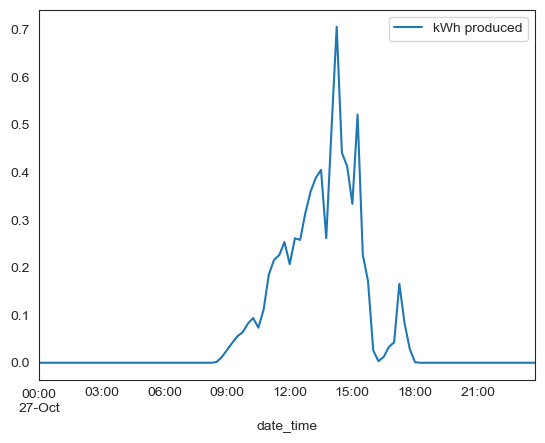

In [434]:
solar["2022-10-27":"2022-10-27"].plot()

We also resample this data to create hourly and daily sums:

In [435]:
# hourly sums
solar_hourly = solar.resample('1H').sum()

# daily sums
solar_daily = solar.groupby(solar.index.date).sum()

## Data from the Smart Meter

The "smart meter" is connected to main electric lines that come into the house and records the totals from four different meters every 15 minutes:<br>
There are two columns that represent the meter readings for imported electricity and two columns that represent the meter readings for exported electricity. <br>
We will add those two columns eventually to create sums of imports and exports.

In [436]:
# importing the data 
path = 'data\home_wizard_data'
csv_files = glob.glob(path + "/*.csv")

df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
big_df   = pd.concat(df_list, ignore_index=True)

# remove duplicates
smart = big_df.drop_duplicates()

In [437]:
# create date/time index
smart = make_datetime_index(smart, 'time')

# delete nan-value rows
smart = smart.dropna()

# to obtain the total amounts imported and exported we 
# need to calculating the difference between rows:
smart_diff = smart.diff(axis=0)
smart_diff = smart_diff.dropna()

# We sum the two import meters and the two export meters
smart_diff['kWh imported'] = smart_diff['Electricity imported T1'] + smart_diff['Electricity imported T2']
smart_diff['kWh exported'] = smart_diff['Electricity exported T1'] + smart_diff['Electricity exported T2']
smart_diff = smart_diff.drop([
    'Electricity imported T1',
    'Electricity imported T2',
    'Electricity exported T1',
    'Electricity exported T2'], axis=1)

smart_diff.head()

,kWh imported,kWh exported
date_time,,
2022-10-06 19:00:00,0.064,0.0
2022-10-06 19:15:00,0.221,0.0
2022-10-06 19:30:00,0.084,0.0
2022-10-06 19:45:00,0.061,0.0
2022-10-06 20:00:00,0.062,0.0


A quick visualization of the data:

<AxesSubplot:xlabel='date_time'>

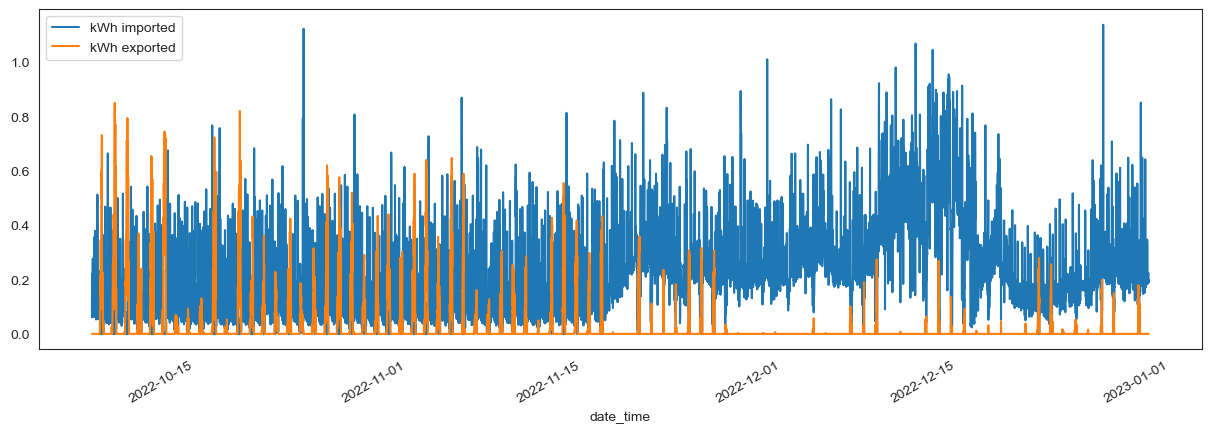

In [438]:
smart_diff.plot(figsize=(15,5))

We also want to obtain hourly and daily sums:

In [439]:
# hourly sums
smart_hourly = smart_diff.resample('1H').sum()

# daily sums
smart_daily = smart_diff.groupby(smart_diff.index.date).sum()

smart_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 2022-10-06 to 2022-12-30
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kWh imported  86 non-null     float64
 1   kWh exported  86 non-null     float64
dtypes: float64(2)
memory usage: 2.0+ KB


Having a look at the daily sums over the entire period:

<AxesSubplot:>

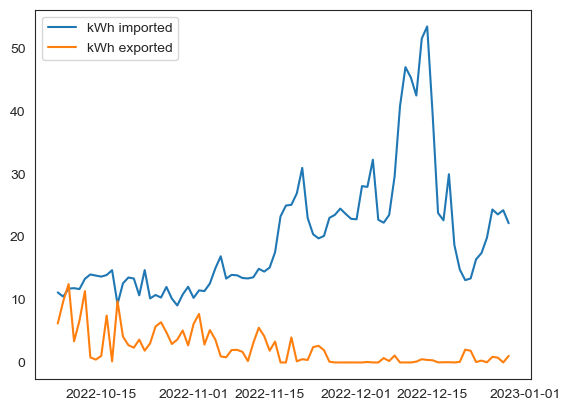

In [440]:
smart_daily[1:-1].plot()

### Combining the Smart Meter Data with the Solar Panel Data

We combine the two dataframes. We will explain why in the next cell.

In [441]:
electricity = solar.join(smart_diff, on="date_time", how="inner")
electricity.sum()

kWh produced     397.650864
kWh imported    1675.217000
kWh exported     192.684000
dtype: float64

The amount of electricity consumed in the household while the solar panels are producing electricity that same amount is not registered by the "smart meter" (not that smart after all). We will call this electricyt "kWh consumed while produced". <br>

The smart meter does however register what is left over from production and fed back into the main elecricty grid. We call this "kWh exported". <br>

By subracting the amount registered from over-production from the actual solar panel output "kWh produced" (which is recorded by the inverter) we can obtain the difference. 

In [442]:
electricity["kWh consumed while produced"] = electricity["kWh produced"] - electricity["kWh exported"]

We then add the smaller amount "kWh consumed while produced" to the amount that the smart meter registered as "kWh imported" to obtain the total amount consumed:

In [443]:
electricity["kWh consumed (total)"] = electricity["kWh consumed while produced"] + electricity["kWh imported"]

# having a look at the data:
electricity.tail()

,kWh produced,kWh imported,kWh exported,kWh consumed while produced,kWh consumed (total)
date_time,,,,,
2022-12-30 07:30:00,0.0,0.201,0.0,0.0,0.201
2022-12-30 07:45:00,0.0,0.188,0.0,0.0,0.188
2022-12-30 08:00:00,0.0,0.214,0.0,0.0,0.214
2022-12-30 08:15:00,0.0,0.218,0.0,0.0,0.218
2022-12-30 08:30:00,0.0,0.222,0.0,0.0,0.222


We also want hourly and daily versions of the electrical data:

In [444]:
electricity_hourly = electricity.resample('1H').sum()
electricity_daily = electricity.resample('1D').sum()

## Data from electricity provider

This data is recored by our utility company ("Greenchoice") throughout the year at the meter box. Essentially it is the same as the "smart meter" data, except for the fact that it has a temporal resolution of 1 day, instead of 15 minutes. <br>
Nevertheless this data is useful because it contains information about a period in which we did not have a smart-meter yet. Specifically it can tell us how much electricity we used in the household without heating or cooling in the summer.<br> 
It will help us to calculate how much electricity the heat pump itself requires.

In [445]:
# importing the data 
path = 'data\greenchoice_data'
csv_files = glob.glob(path + "/*.csv")

df_list = (pd.read_csv(file, sep=";") for file in csv_files)

# Concatenate all DataFrames
big_df   = pd.concat(df_list, ignore_index=True)

# remove duplicates
greenchoice = big_df.drop_duplicates()

# create date/time index
greenchoice = make_datetime_index(greenchoice, 'OpnameDatum')

# sorting index in ascending order
green = greenchoice.sort_index()

# we drop the first 5 rows we don't need
green = green[5:]

# to obtain the total amounts imported and exported we 
# need to calculating the difference between rows:
green_diff = green.diff(axis=0)
green_diff = green_diff.dropna()

# We sum the two import meters and the two export meters
green_diff['kWh imported'] = green_diff['StandNormaal'] + green_diff['StandDal']
green_diff['kWh exported'] = green_diff['TerugleveringNormaal'] + green_diff['TerugleveringDal']

green_diff = green_diff.drop([
    'StandNormaal',
    'StandDal',
    'TerugleveringNormaal',
    'TerugleveringDal'], axis=1)

green_diff.head()

,kWh imported,kWh exported
date_time,,
2022-05-19,2.0,15.0
2022-05-20,6.0,12.0
2022-05-21,7.0,12.0
2022-05-22,6.0,18.0
2022-05-23,6.0,20.0


We select the time frame in which we did not use the heatpump for heating.

In [446]:
summer = green_diff['2022-08-01':'2022-09-18']

We further filter out the days in which we used the heatpump for coolin the summer.

In [447]:
base_consumption = summer[(summer.index < '2022-08-09') | (summer.index > '2022-08-16')]

We join this data with the solar panel data. We will explain why in the next cell.

In [448]:
base = base_consumption.join(solar_daily, how="inner")

Just as with the "smart meter" data we need to calculate the actual amount of electricity used by adding the amount of imported electricity to the difference between the amount we produced and the amount we exported:

In [449]:
base['kWh consumed'] = base['kWh imported'] + (base['kWh produced'] - base['kWh exported'])
base['kWh consumed'].describe()

count    41.000000
mean      7.998952
std       7.607150
min     -11.660761
25%       4.375876
50%       8.140476
75%      12.631725
max      29.209377
Name: kWh consumed, dtype: float64

We obtain the average electricity consumption for those weeks in the summer:

In [450]:
mean_base_consumption = base['kWh consumed'].mean()
mean_base_consumption

7.998952219203901

So, without using the heatpump for heating or cooling we use approximately 8 kWh of electricity per day.

## Data from thermometers placed inside and outside the house.

I have placed thermometers in a few areas in the house and also outside of the house.<br>
We need this data to determine how much work the heatpump actually has to do.<br>
The data comes in CSV files and has a temporal resolution of 1 minute.

In [451]:
# defining the room names (OAT = Outside Air Temperature)
rooms = ["bad", "garage", "OAT", "slaapki", "slaapou", "speel", "werk", "woon"]

# importing the data into one single dataframe:
for room in rooms:
    path = "data/thermometer_data/" + room
    csv_files = glob.glob(path + "/*.csv")
    df_list = (pd.read_csv(file) for file in csv_files)
    # Concatenate all DataFrames
    big_df   = pd.concat(df_list, ignore_index=True)
    big_df = big_df.drop_duplicates()
    big_df = make_datetime_index(big_df,"Date")
    big_df = big_df.rename(columns={'Temperature_Celsius(℃)': room + ' temp (C)' ,'Relative_Humidity(%)' : room + ' rh (%)'})

    # assign variable
    globals()[room] = big_df

We also want to obtain daily and hourly averages.<br>
Eventually we will only need the series from the hourly averages in the living room (woon_hourly) and the hourly averages from outside the house (outside_hourly):

In [452]:
# Averages from the living room area
woon_hourly = woon.resample('1H').mean()
woon_daily = woon.resample('1D').mean()

# Averages from a thermometer placed outside
outside_hourly = OAT.resample('1H').mean()
outside_daily = OAT.resample('1D').mean()

### Comparing temperature recorded at the house against that from the weather station

We want to get an idea if the temperature recordings at our house are realistic, or if there are any major errors. So we compare the outside air temperature recoded at our house with that recorded at the nearest weather station:

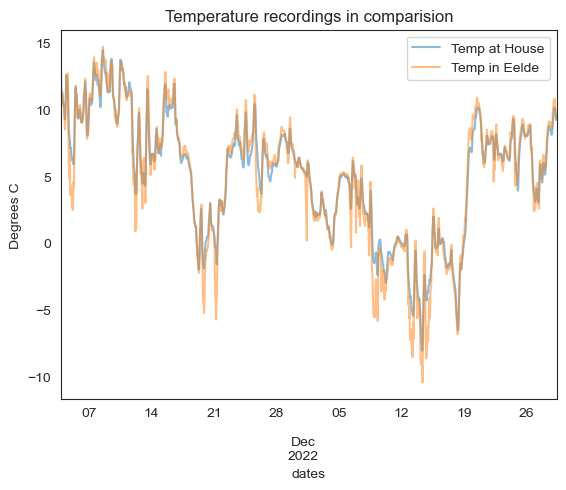

In [453]:
import matplotlib.pyplot as plt

oat_house = outside_hourly["OAT temp (C)"]
eelde_temp = wind_temp["OAT Eelde (C)"]
oatjoin = pd.DataFrame(eelde_temp).join(oat_house, how='inner')


fig, ax = plt.subplots()
oatjoin[["OAT temp (C)","OAT Eelde (C)"]].plot(ax=ax, title ='Temperature recordings in comparision', alpha=0.5, xlabel="dates", ylabel="Degrees C")
ax.legend(["Temp at House", "Temp in Eelde"])

Eelde's outside air temperature (13km distance from our house) occasionally seems be a few degrees lower than at the house. <br>

## Data from the heat pump settings

The settings of the heatpump can be changed manually to essentially influence the temperature in the house. Any change usually takes one to a few days to take effect, since the system is dependend on large-body warming elements that take a long time to warm up or cool down.<br>
Of course, the heatpump also has it own internal temperature sensors that react as soon as it gets colder outside, but that data is not obtainable.<br>
I recorded the manual changes of the settings in a CSV file.

In [454]:
# importing the data
heatpump = pd.read_csv("data\heatpump_data\heatpump2.csv")
heatpump = make_datetime_index(heatpump, 'Date')

The on/off settings are recorded as binary values.<br>
Two of the settings allow for adjustment of the temperature of the water-output, namely "Stooklijn", where the temperature can be set and "Adjust", which is a fine adjustment of the same parameter. <br>
The final output temperature is calculated by adding the two parameters:

In [455]:
heatpump['Heatpump Temp'] = heatpump["Stooklijn"] + heatpump["Adjust"]

Since the CSV file only contains the dates/times when manual changes were actually done, we need to forward fill the data to the remaining dates/times the heatpump was operating:

In [456]:
# filling the mostly empty dataframe
idx = pd.date_range(heatpump.index.min(), end=pd.Timestamp.today()   ,freq='1H')
heatpump = heatpump.reindex(idx, method='ffill')
heatpump.tail()

,Autoverwarmen,Continuuwerking,Stooklijn,Adjust,AtHome,Heatpump Temp
2023-01-04 08:00:00,0,1,37,1.0,1,38.0
2023-01-04 09:00:00,0,1,37,1.0,1,38.0
2023-01-04 10:00:00,0,1,37,1.0,1,38.0
2023-01-04 11:00:00,0,1,37,1.0,1,38.0
2023-01-04 12:00:00,0,1,37,1.0,1,38.0


# Combining the data

Finally, we will build one single dataframe that contains data from:
- Official weather station (hourly average of temperature and sums of radiation and sunshine duration)
- Thermometer (hourly data from living room and from outside)
- Heatpump (hourly mean temperature of water that flows out)
- Combined Smart meter and solar panels (kWh consumed in total)

In [457]:
combined_df = pd.DataFrame(electricity_hourly["kWh consumed (total)"]).join(woon_hourly["woon temp (C)"], how='inner')
combined_df = combined_df.join(
    (outside_hourly["OAT temp (C)"],
    weather['OAT Eelde (C)'],
    heatpump["Heatpump Temp"],
    weather['wind speed (m/s)'],
    weather['global radiation (J/cm2)'],
    weather['sunshine duration (hrs)']
), how="inner")

We also construct some extra features that are calculated from the existing features and hopefully will provide useful:

In [458]:
combined_df["Inside Temp above Outside Temp"] = combined_df["woon temp (C)"] - combined_df["OAT temp (C)"]
combined_df["Inside Temp above Outside Temp (rolling)"] = combined_df["Inside Temp above Outside Temp"].rolling(24).mean()
combined_df["Heatpump Temp above Inside Temp"] = combined_df["Heatpump Temp"] - combined_df["woon temp (C)"]
combined_df["Heatpump Temp above Inside Temp (rolling)"] = combined_df["Heatpump Temp above Inside Temp"].rolling(24).mean()
combined_df["Rolling average kWh consumption"] = combined_df["kWh consumed (total)"].rolling(24).mean()

Lets have a look at all the features now:

In [459]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1334 entries, 2022-11-03 21:00:00 to 2022-12-29 10:00:00
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   kWh consumed (total)                       1334 non-null   float64
 1   woon temp (C)                              1334 non-null   float64
 2   OAT temp (C)                               1334 non-null   float64
 3   OAT Eelde (C)                              1334 non-null   float64
 4   Heatpump Temp                              1334 non-null   float64
 5   wind speed (m/s)                           1334 non-null   float64
 6   global radiation (J/cm2)                   1334 non-null   float64
 7   sunshine duration (hrs)                    1334 non-null   float64
 8   Inside Temp above Outside Temp             1334 non-null   float64
 9   Inside Temp above Outside Temp (rolling)   1311 non-null   f

## Heatpump demand versus electricity consumption

In the wintertime he desired temperature in the house is between 20 and 21 degrees.<br>
The colder it gets outside, the harder the heatpump has to work to maintain the temperature inside. For most days, the heatpump will be the largest elecrical consumer and the electricity consumpter per day will mostly depend on how much work the heatpump has to do.<br>
I therefore suspect that there is a relationship between the difference of the inside and outside temperature and the total amount of electricity consumed per day.<br>

We will plot electric consumption together with the fluctuations of temperature difference between inside and outside in one graph:

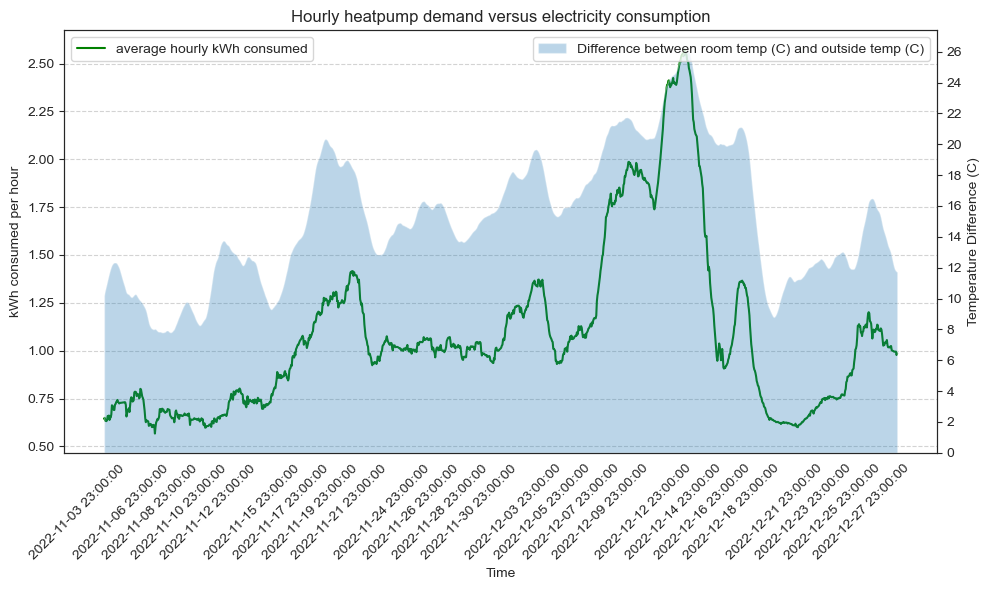

In [460]:
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
ax.set_title("Hourly heatpump demand versus electricity consumption")
ax.set_xlabel('Time')
ax2.stackplot(combined_df.index, combined_df["Inside Temp above Outside Temp (rolling)"], alpha=0.3)
ax.plot(combined_df.index, combined_df["Rolling average kWh consumption"], color='green')

ax.set_ylabel("kWh consumed per hour")
ax2.set_ylabel("Temperature Difference (C)")
ax.legend(["average hourly kWh consumed"], loc='upper left')
ax2.legend(["Difference between room temp (C) and outside temp (C)"], loc='upper right')
ax.set_xticks(combined_df.index.date, interval=24)
ax.set_xticklabels(combined_df.index, rotation=45)
ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.locator_params(axis='both', nbins=25)
plt.savefig('graphs\Hourly heatpump demand versus electricity consumption.png')
plt.show()

# Choosing Predictor variables to build a model

We want to predict kWH consumed. So, kWh is the dependent variable. To discover linear relationships between the variables we will have a look at scatterplots from kWh combined with every other variable:

In [461]:
sns.pairplot(combined_df, kind='reg', plot_kws={'line_kws':{'color': 'cyan'}})

Taking a closer look at one of the scatter plots:

<AxesSubplot:xlabel='Inside Temp above Outside Temp', ylabel='kWh consumed (total)'>

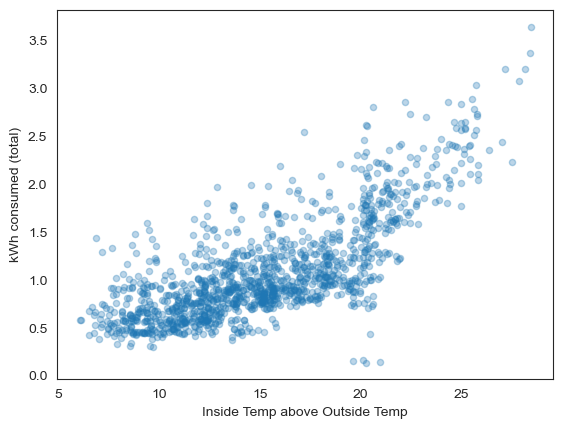

In [ ]:
combined_df.plot(x = "Inside Temp above Outside Temp", y="kWh consumed (total)", kind="scatter", alpha=0.3)

There are some outliers at around 20C just above the x-axis. <br>
A look into our personal calender reveals that we were not home from the 16th until the 25th of december. So our normal electricity usage pattern does not apply to those days. The outliers in the data exactly match those days. We will remove those days from the data.<br>

Also, we observe that the relationship between "kWh consumed (total)" and the other variables might not be exactly linear. <br>
Therefore we include a log transformation of the dependent variable in our analysis:

In [ ]:
# removing the outliers and renaming the data
mask = (combined_df.index < '2022-12-16') | (combined_df.index >= '2022-12-25')
data = combined_df.loc[mask]

# adding the log transformation to the dependent variable
data["log kWh"] = np.log(data["kWh consumed (total)"])

To get a bit more subjective information about the correlation we compute the pairwise with the Pearson correlation coefficient:

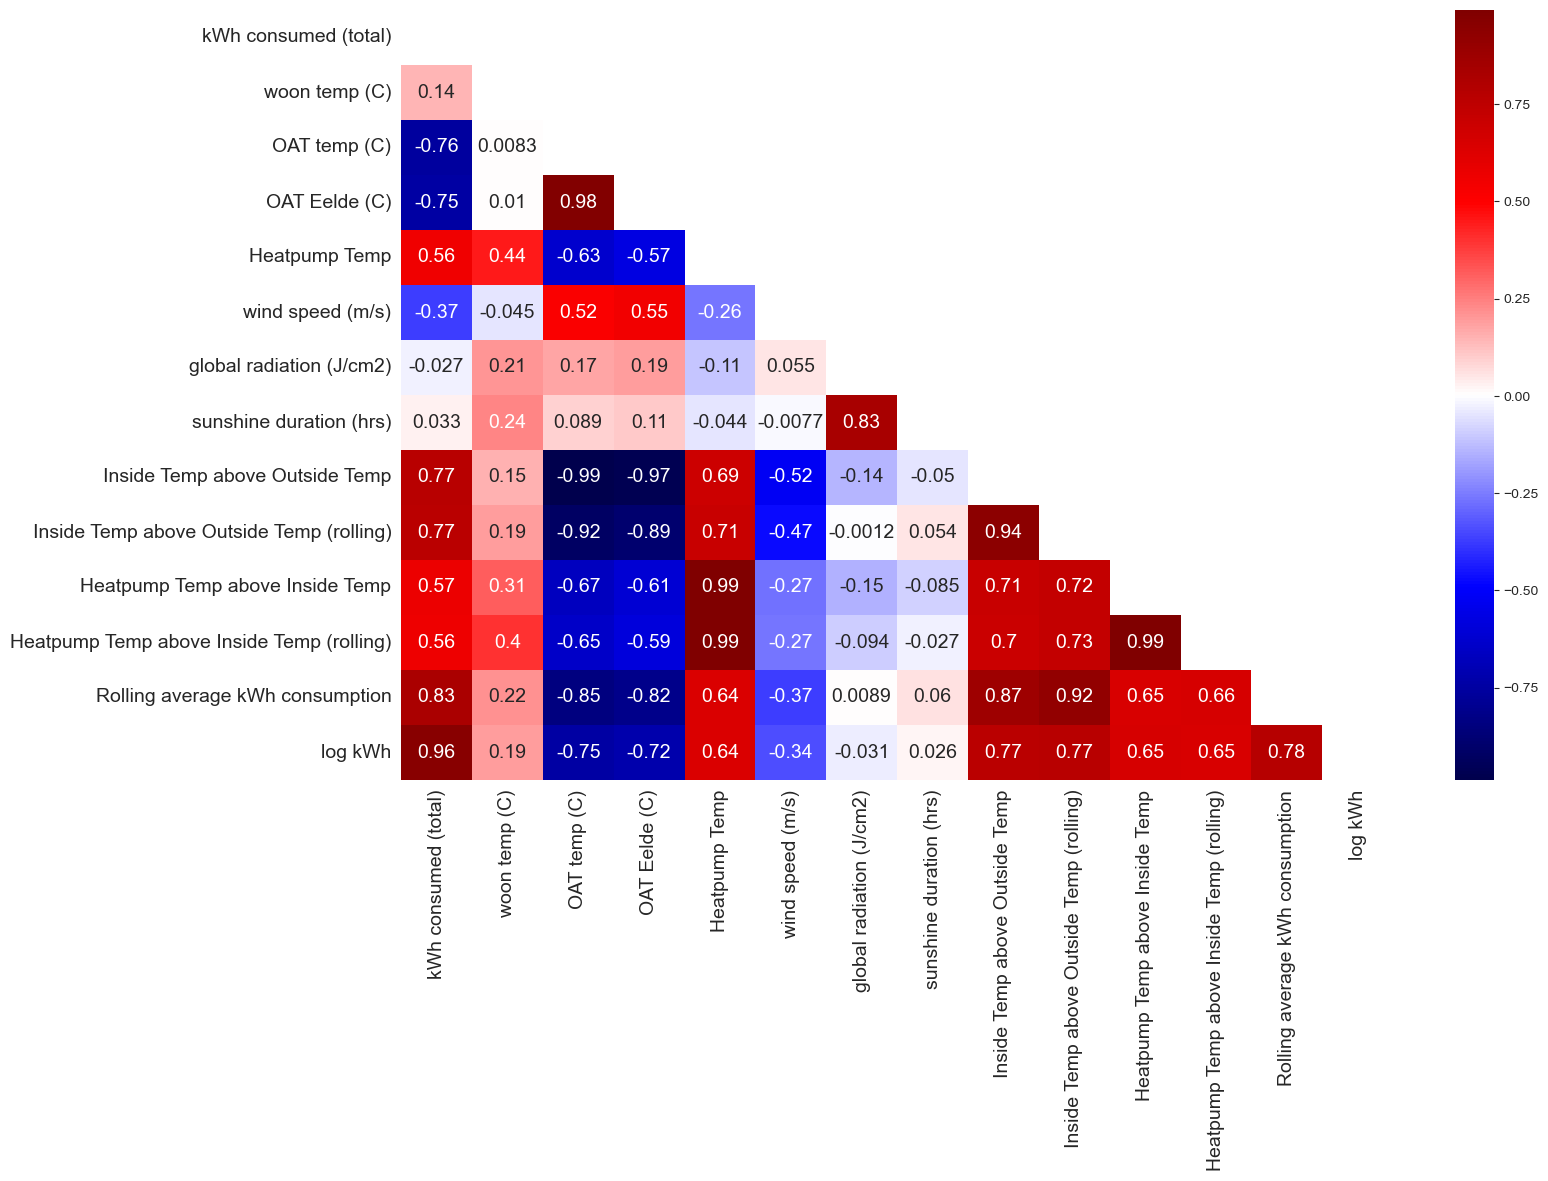

In [ ]:
# heatmap of correlation factors
mask = np.zeros_like(data.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), mask=mask, annot=True, annot_kws={"size": 14}, cmap="seismic")
#sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

- Looking at the heat map it is not clear yet if the log transformation adds any value to the model. <br>
- To my dissapointment sunshine duration and global radiation do not seem to add any value to the model.<br>
- There seems to be only a weak correlation between wind-speed and kWh consumed.<br>
- The strongest linear relationships exist between "kWh consumed (total)" and "Inside Temp above Outside Temp".<br>
- Most of the other variables are related to "Inside Temp above Outside Temp" and will not be used in the final model.<br>
- We may still consider including "Heatpump Temp" (the water output temperature of the heatpump) and "Windspeed".

A last look at the correlation bewteen "kWh consumed (total)" and the other variables:

In [ ]:
energy = abs(data.corr())
energy["kWh consumed (total)"].sort_values(ascending = False)

kWh consumed (total)                         1.000000
log kWh                                      0.959526
Rolling average kWh consumption              0.826260
Inside Temp above Outside Temp               0.773852
Inside Temp above Outside Temp (rolling)     0.767981
OAT temp (C)                                 0.759537
OAT Eelde (C)                                0.746079
Heatpump Temp above Inside Temp              0.568161
Heatpump Temp above Inside Temp (rolling)    0.561704
Heatpump Temp                                0.557427
wind speed (m/s)                             0.368845
woon temp (C)                                0.144395
sunshine duration (hrs)                      0.033279
global radiation (J/cm2)                     0.026941
Name: kWh consumed (total), dtype: float64

Here we plot the independent variable against "Inside Temp above Outside Temp" with a regression line:

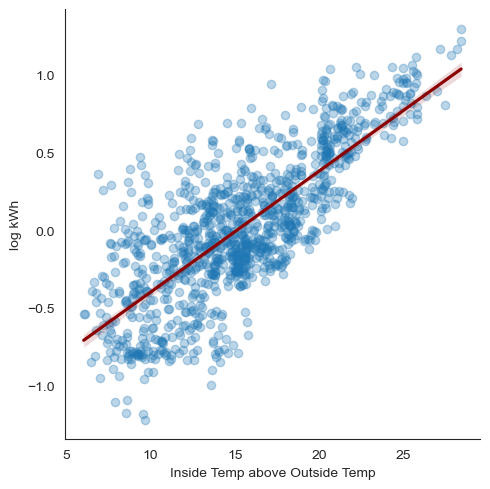

In [ ]:
sns.lmplot(x="Inside Temp above Outside Temp", y='log kWh', data=data, height=5, 
           scatter_kws={'alpha': 0.3}, line_kws={'color':'darkred'})
plt.show()

So far we have used data with a temporal resolution of 15 minutes. But the total electricity consumption in the household fluctuates considerably depending on the time of the day. For example showering in the Morning or cooking in the evening are events that drive those fluctuations.<br>
Plotting the daily average electricity consumption in 15 minute intervals demonstrates this:

<AxesSubplot:xlabel='date_time,date_time'>

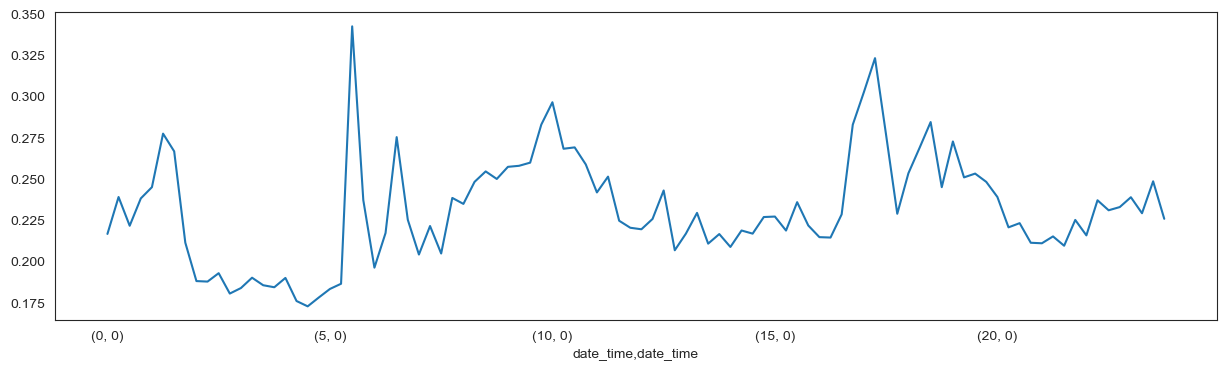

In [ ]:
electricity["kWh consumed (total)"].groupby([electricity.index.hour, electricity.index.minute]).mean().plot(figsize=(15,4))

So, to get rid of those fluctions we will obtain daily sums/averages of the data to see if we can get higher correlations.

Earlier we calculated the daily average amount of kWh consumed in the summer, when the heatpump was not used for cooling or heating. We will create a new variable "Heatpump consumption (kWh)" which is the daily total electricity consumption minus the amount we determined earlier for the summer months.

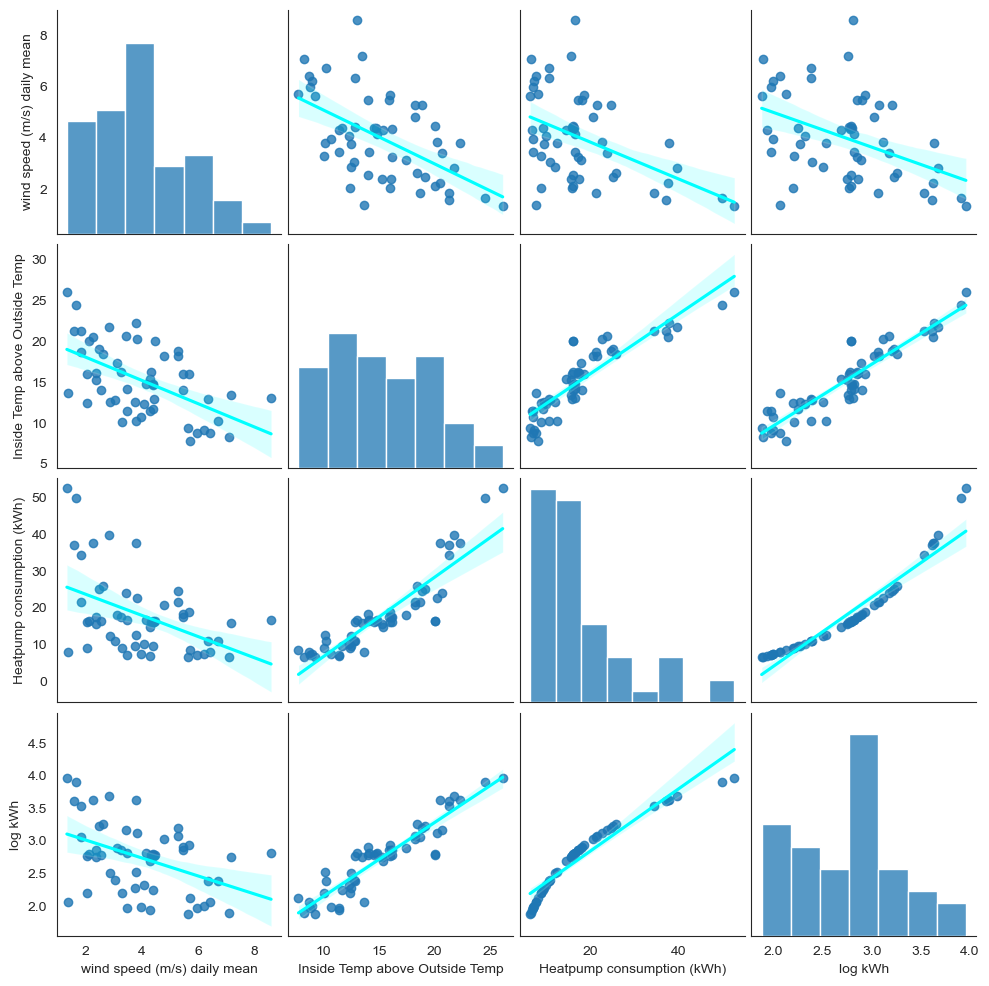

In [ ]:
temp_diff = combined_df['Inside Temp above Outside Temp'].groupby(combined_df.index.date).mean()
kWh_daily = combined_df['kWh consumed (total)'].groupby(combined_df.index.date).sum()

daily = wind_temp_daily.join(
    (sun_radiation_daily['global radiation (J/cm2) daily sum'],
    kWh_daily, temp_diff,
), how="inner")

# we also drop the first and last day, because the data is not complete for those days
daily = daily[1:-1]

# subracting the average daily base consumption
daily['Heatpump consumption (kWh)'] = daily['kWh consumed (total)'] - mean_base_consumption

# including a log transformation here as well
daily['log kWh'] = np.log(daily['Heatpump consumption (kWh)'])

# dropping columns not needed any longer
daily = daily.drop(['OAT Eelde (C) daily mean','global radiation (J/cm2) daily sum','kWh consumed (total)'], axis=1)


sns.pairplot(daily, kind='reg', plot_kws={'line_kws':{'color': 'cyan'}})

In [ ]:
energy = abs(daily.corr())
energy['log kWh'].sort_values(ascending = False)

log kWh                           1.000000
Heatpump consumption (kWh)        0.950045
Inside Temp above Outside Temp    0.926443
wind speed (m/s) daily mean       0.431507
Name: log kWh, dtype: float64

In [ ]:
energy = abs(daily.corr())
energy['Heatpump consumption (kWh)'].sort_values(ascending = False)

Heatpump consumption (kWh)        1.000000
log kWh                           0.950045
Inside Temp above Outside Temp    0.895857
wind speed (m/s) daily mean       0.457165
Name: Heatpump consumption (kWh), dtype: float64

The correlations are now considerably higher. We continue with the daily data to build a model.

# Building a multivariable regression model

It is time that we build the model and define the predictor variables and the dependent variables.<br>
For now, we will only use "Inside Temp above Outside Temp" and "wind speed" in the model.

In [ ]:
X = daily.drop([
    'Heatpump consumption (kWh)','log kWh']
    , axis=1)

y = daily['log kWh']

Splitting the data into a training and test data set:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

Fitting a Multiple Linear Regression Model:

In [ ]:
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

# Evaluating the model

We evaluate the model with
- the coefficient of determination ($R^2$) on the Training- and the Test-Data
- the Bayesian Information Criterion
- the Variance Inflation Factor for each predictor variable

In [ ]:
# using Statsmodel
X_incl_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_incl_const) # ordinary least squares model
results = model.fit()

# Variance Inflation factor for all features
vif = [variance_inflation_factor(exog=X_incl_const.values, 
                                 exog_idx=i) for i in range(X_incl_const.shape[1])]

# r-Squared on Training and Test data
print('Training data r-squared:', round(regr.score(X_train, y_train), 3))
print('Test data r-squared    :', round(regr.score(X_test, y_test),3))


# p-values and vif
org_coef = pd.DataFrame({'coefficient': round(results.params,3), 'p-value': round(results.pvalues, 3),'vif': np.around(vif, 2)})

# BIC and R-Squared
print('BIC                    :', round(results.bic,3))

# The intercept
print('Intercept              :', round(regr.intercept_, 3))

org_coef

Training data r-squared: 0.902
Test data r-squared    : 0.528
BIC                    : -16.65
Intercept              : 0.589


,coefficient,p-value,vif
const,0.589,0.002,43.66
wind speed (m/s) daily mean,0.043,0.044,1.57
Inside Temp above Outside Temp,0.129,0.000,1.57


## Interpretation of metrics

- With 90% the $R^2$ looks good for the training data-set. The test data-set is quite small, this may explain the relative low $R^2$.
- The BIC is lower than all other tested models (not shown here).
- The VIF is below 10 for each feature, thus not indicating any serious problems.
- The p-values are lower than 0.05, thus not indicating any problem. 
- We will re-evaluate the model when we have more data available. 

## Residual Plots

Let's plot the predicted versus the actual values and also the residuals versus the actual values:

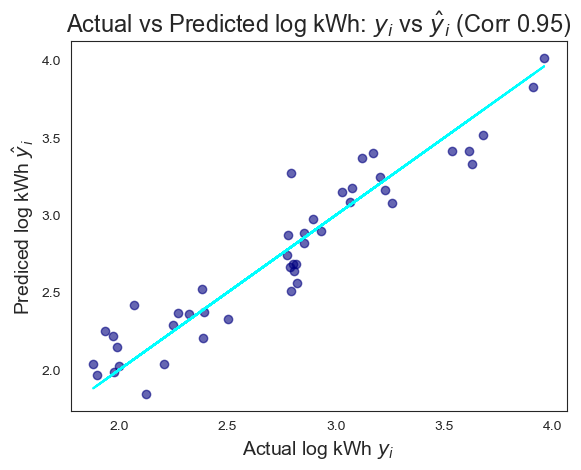

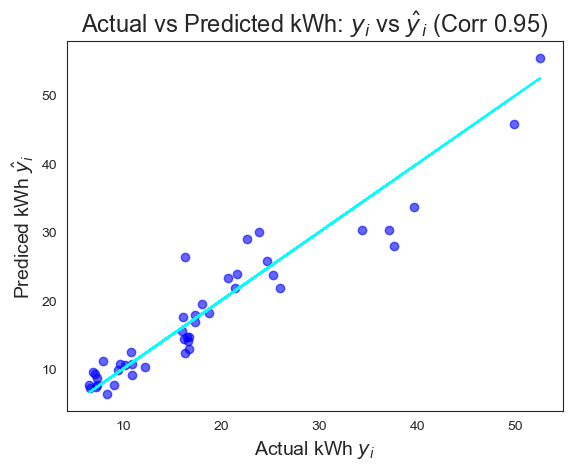

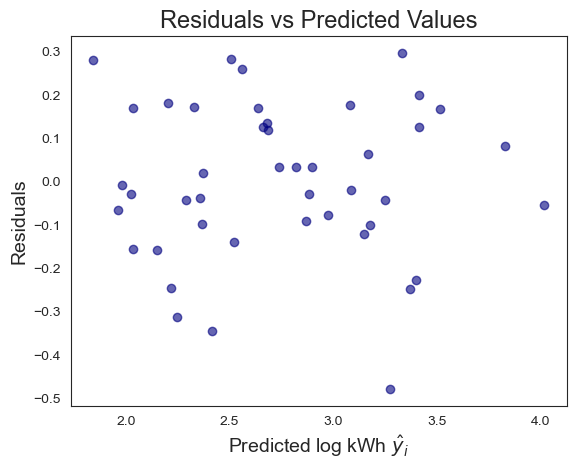

In [ ]:
# correlation between actual values and the results of models prediction
corr = round(y_train.corr(results.fittedvalues), 2)

# Actual log kWh vs Predicted log kWh
plt.scatter(x=y_train, y=results.fittedvalues, c='navy', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')
plt.xlabel('Actual log kWh $y _i$', fontsize=14)
plt.ylabel('Prediced log kWh $\hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted log kWh: $y _i$ vs $\hat y_i$ (Corr {corr})', fontsize=17)
plt.show()

# Actual kWh vs Predicted kwH
plt.scatter(x=np.e**y_train, y=np.e**results.fittedvalues, c='blue', alpha=0.6)
plt.plot(np.e**y_train, np.e**y_train, color='cyan')
plt.xlabel('Actual kWh $y _i$', fontsize=14)
plt.ylabel('Prediced kWh $\hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted kWh: $y _i$ vs $\hat y_i$ (Corr {corr})', fontsize=17)

plt.show()

# Residuals vs Predicted values
plt.scatter(x=results.fittedvalues, y=results.resid, c='navy', alpha=0.6)
plt.xlabel('Predicted log kWh $\hat y _i$', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Predicted Values', fontsize=17)
plt.show()

# Mean Squared Error & R-Squared
reduced_log_mse = round(results.mse_resid, 3)
reduced_log_rsquared = round(results.rsquared, 3)

We can evaluate the normality a little bit better by plotting the residuals in a histogram:

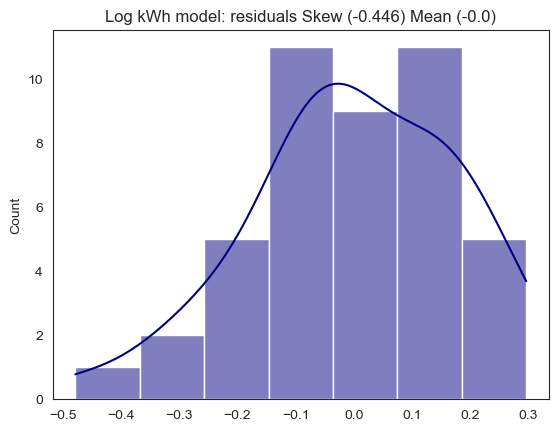

In [ ]:
# Distribution of Residuals (log prices) - checking for normality
resid_mean = round(results.resid.mean(), 3)
resid_skew = round(results.resid.skew(), 3)

sns.histplot(results.resid, kde=True, color="navy")
#sns.distplot(results.resid, color='navy')
plt.title(f'Log kWh model: residuals Skew ({resid_skew}) Mean ({resid_mean})')
plt.show()

The residuals histogram shows a distinct skew to the left. <br>
However, given the low number of residuals we do not give this fact too much weight.<br>
With a few more months worth of data in the future we will re-evaluate this plot. 

# Interpretation of model

$$ (InsideTemp - OutsideTemp) * 0.129 \ kWh + WindSpeed * 0.043 \ kWh + 0.589 \ kWh = ln(kWh)$$
or
$$ e^{(InsideTemp - OutsideTemp) * 0.129 \ kWh + WindSpeed * 0.043 \ kWh + 0.589 \ kWh} = kWh$$

where:<br> 
- InsideTemp = temperature inside the house in Celcius<br>
- OutsideTemp = temperature outside the house in Celecius<br>
- WindSpeed = speed of the wind in meters per second.<br>
- kWh = Kilowatt hours of electricity consumed by the heatpump.<br>

So, for example:<br>

If the temperature inside is 20C, outside is 5C, and the wind is blowing with 2m/s, then daily energy consumption by the heatpump would be:

$$ e^{(20 - 5) * 0.129 \ kWh + 2 * 0.043 \ kWh + 0.589 \ kWh} = kWh$$

Lets create a function that can perform this calculation:

In [ ]:
def calculate_kWh(inside_temp, outside_temp, wind):
    kWh = round(np.e**((inside_temp - outside_temp) * results.params[2] + wind * results.params[1] + results.params[0]),3)
    return kWh

calculate_kWh(20, 5, 2)

13.646

So, with the conditions given, the heatpump will consume about 13.6 kWh per day.

Providing a 95% prediction interval for the lower and upper bound of the kWh consumption:

In [ ]:
print('1 s.d. in log kWh is', np.sqrt(reduced_log_mse))
print('2 s.d. in log kWh is', 2*np.sqrt(reduced_log_mse))

lower_bound = np.log(13.6) - 2*np.sqrt(reduced_log_mse)
print('The lower bound in log kWh for a 95% prediction interval is ', lower_bound)
print('The lower bound in normal kWh is ', np.e**lower_bound)

upper_bound = np.log(13.6) + 2*np.sqrt(reduced_log_mse)
print('The upper bound in log kWh for a 95% prediction interval is ', upper_bound)
print('The upper bound in normal kWh is', np.e**upper_bound)



1 s.d. in log kWh is 0.1816590212458495
2 s.d. in log kWh is 0.363318042491699
The lower bound in log kWh for a 95% prediction interval is  2.2467517502503074
The lower bound in normal kWh is  9.456967299802063
The upper bound in log kWh for a 95% prediction interval is  2.9733878352337055
The upper bound in normal kWh is 19.558066992985296


I am curious what the electricity demand will be at a constant temperature of 20.5 degrees inside (our prefered temperature at home) while the outside temperature ranges between -10 degrees to + 20 degrees outside:

<AxesSubplot:title={'center':'Daily electricity consumption at 20C inside temperature'}, xlabel='Outside Temperature (C)', ylabel='electricity used (kWh)'>

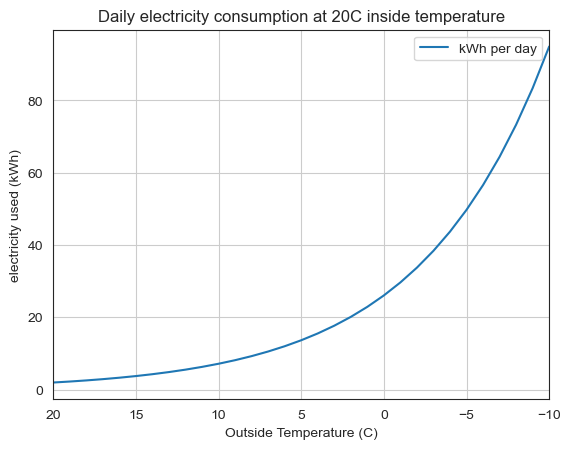

In [ ]:
outside_temp = np.arange(-10, 21)
inside_temp = 20
wind = 2
power = []

for temp in outside_temp:
    kWh = calculate_kWh(inside_temp, temp , wind)
    power.append(kWh)

df = pd.DataFrame(power, outside_temp, columns=["kWh per day"])
df = df.sort_index(ascending=False)

df.plot(title=f"Daily electricity consumption at {inside_temp}C inside temperature",xlabel="Outside Temperature (C)", ylabel="electricity used (kWh)", grid=True, xlim=(20,-10))

It does not surpise that this function looks like an exponential function, since we used it in the model. <br>
So the electricity demand of the heat pump rises exponentially the colder it gets outside.

Conclusion: when it is cold outside, wear an extra sweater!

# Making an 8-day forecast for the demand of electricity.

We will make an 8-day forecast for the amount of electricity demanded by the heat pump. We will be using a freely available weather forecast from https://open-meteo.com/. We can obtain a temperature and a wind forecast from th site.<br>
First we import the data over an api and transform it into a dataframe. Then we bring it into the format that we need it in to feed into the prediction algorithm we created earlier.

In [ ]:
# Convert an API JSON Response to a Python Dictionary
import requests

# temperature in Celcius
url = 'https://api.open-meteo.com/v1/forecast?latitude=53.16&longitude=6.76&hourly=temperature_2m'
response = requests.get(url)
data = response.json()
temperature = pd.DataFrame.from_dict(data['hourly'])
temperature = make_datetime_index(temperature, 'time')

# windspeed in km/h
url = 'https://api.open-meteo.com/v1/forecast?latitude=53.16&longitude=6.76&hourly=windspeed_10m'
response = requests.get(url)
data = response.json()
wind = pd.DataFrame.from_dict(data['hourly'])
wind = make_datetime_index(wind, 'time')

# joining the two dfs
weather = temperature.join(wind, how="inner")

# converting the date-time index to local time
weather.index = weather.index.tz_localize('utc').tz_convert('Europe/Amsterdam')

# converting windspeed from km/h to m/s
weather['windspeed'] = weather["windspeed_10m"] * 0.277778
weather = weather.drop(['windspeed_10m'], axis=1)

# creating daily averages
weather_forecast = weather.resample('1D').mean()

# removing the hour information
weather_forecast.index = weather_forecast.index.date

weather_forecast.head()

,temperature_2m,windspeed
2023-01-04,10.391304,7.736721
2023-01-05,9.320833,4.875004
2023-01-06,8.616667,5.115745
2023-01-07,8.562500,4.326392
2023-01-08,7.704167,4.622689


With the temperature and wind forcast formatted properly we can now make a electricity demand forecast for the heatpump:

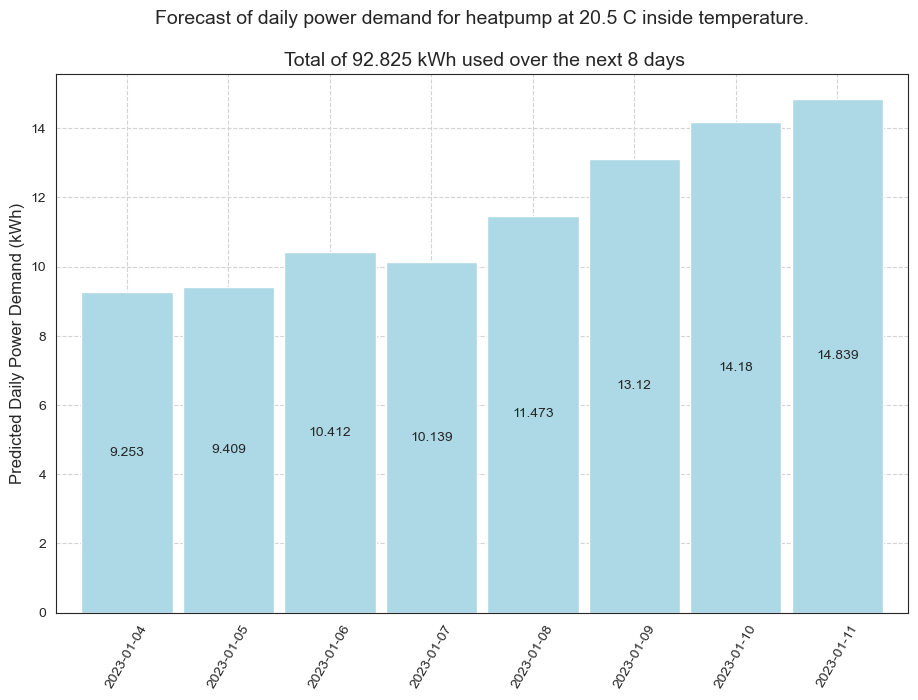

In [ ]:
inside_temp = 20.5

power = []

# using the algorithm we wrote earlier
for index, row in weather_forecast.iterrows():
    kWh = calculate_kWh(inside_temp, row['temperature_2m'],row['windspeed'])
    power.append(kWh)

power_forecast = pd.DataFrame (power, columns = ['Predicted kWh'])
power_forecast = power_forecast.set_index(weather_forecast.index)

# the total amount of kWh over the perdiod of the forecast
total_power = power_forecast['Predicted kWh'].sum()

# plotting the forecast daily power demand
plt.figure(figsize=(11, 7))
fig = round(power_forecast['Predicted kWh'],3).plot(kind='bar', width=0.9, color='lightblue')
fig.set_xticklabels(power_forecast.index)
fig.bar_label(fig.containers[0], label_type='center')
# ax = plt.axes()
# ax.set_facecolor('whitesmoke')

#plt.xlabel('Dates', fontsize=12)
plt.ylabel('Predicted Daily Power Demand (kWh)', fontsize=12)
plt.title(f'Forecast of daily power demand for heatpump at {inside_temp} C inside temperature.\n \n Total of {round(total_power,3)} kWh used over the next {len(power_forecast)} days',
fontsize=14)
plt.grid(color='lightgray', linestyle='dashed')
plt.xticks(fontsize=10, rotation=60)
plt.yticks(fontsize=10)
plt.savefig(f'graphs\{len(power_forecast)}-day forecast at defined inside temp.png')
plt.show()

We predict the total power demand of the heat pump for the next 8 days at different desired temperatures inside of the house:

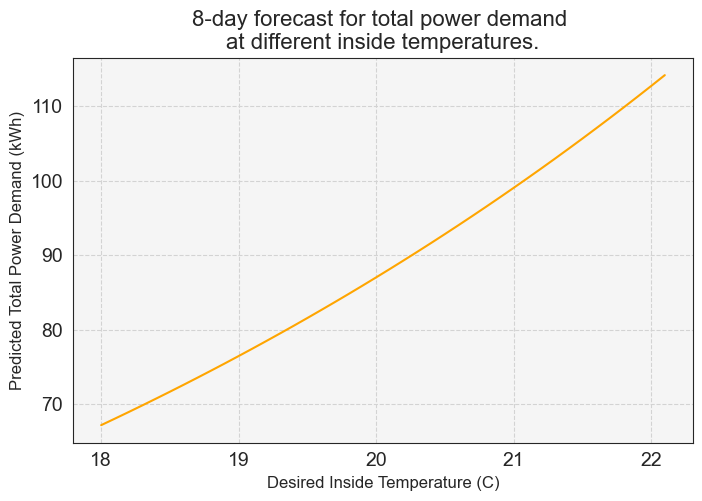

In [ ]:
inside_temp = np.arange(18,22.1,0.1)

power_variable =[]

# using the algorithm we wrote earlier
for temp in inside_temp:
    power = []
    for index, row in weather_forecast.iterrows():
        kWh = calculate_kWh(temp, row['temperature_2m'],row['windspeed'])
        power.append(kWh)
    sum_power = sum(power)
    power_variable.append(sum_power)


power_forecast_variable = pd.DataFrame(power_variable, columns = ['8-day kWh demand'])

power_forecast_variable = power_forecast_variable.set_index(inside_temp)


# plotting the forecast daily power demand
plt.figure(figsize=(8,5))
ax = plt.axes()
ax.set_facecolor('whitesmoke')
plt.plot(power_forecast_variable, color='orange')
plt.xlabel('Desired Inside Temperature (C)', fontsize=12)
plt.ylabel('Predicted Total Power Demand (kWh)', fontsize=12)
plt.title(f'{len(power_forecast)}-day forecast for total power demand \nat different inside temperatures.',fontsize=16)
plt.grid(color='lightgray', linestyle='dashed')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'graphs\{len(power_forecast)}-day forecast at different temps.png')
plt.show()
